# Image Captioning with Data Leakage Prevention

## 🎯 **Enhanced Pipeline Design**

This notebook implements a scientifically sound pipeline that prevents data leakage between training and test sets. Key improvements:

1. **Early Train/Test Split**: Split image IDs BEFORE augmentation and tokenization
2. **Training-Only Tokenization**: Fit vocabulary only on training captions
3. **Training-Only Augmentation**: Augment only training images, keep test set original
4. **Clean Evaluation**: Unbiased test results with proper data separation

## ⚠️ **Critical Pipeline Order**
```
1. Load Captions → 2. Split Image IDs → 3. Train-Only Tokenization → 
4. Train-Only Augmentation → 5. Feature Extraction → 6. Training
```

This ensures **NO DATA LEAKAGE** between training and test sets.

In [1]:
import time
start_time = time.time()
print("🚀 Starting Image Captioning Pipeline with Data Leakage Prevention")

🚀 Starting Image Captioning Pipeline with Data Leakage Prevention


# Step 1: Import Libraries and Setup

Setting up all necessary libraries and project directories.

In [2]:
# ==== TensorFlow GPU Setup (Single Combined Block) =========================================
import os, sys, site

# --- 0) Environment setup BEFORE importing TensorFlow ---
# Prevent loading packages outside the virtual environment
os.environ["PYTHONNOUSERSITE"] = "1"
# Choose GPU device (change index if needed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Allow TensorFlow to grow GPU memory usage instead of allocating all at once
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# Disable cuDNN RNN for compatibility
os.environ['TF_DISABLE_CUDNN_RNN'] = '1'

# --- 1) Import TensorFlow ---
import tensorflow as tf

# --- 2) Basic environment information ---
print("PY:", sys.executable)
print("TF Version:", tf.__version__)
print("TF File:", tf.__file__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("SITE:", site.getsitepackages())
print("USER SITE:", site.getusersitepackages())
print("ENV  CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("ENV  TF_FORCE_GPU_ALLOW_GROWTH:", os.environ.get("TF_FORCE_GPU_ALLOW_GROWTH"))
print("ENV  TF_DISABLE_CUDNN_RNN:", os.environ.get("TF_DISABLE_CUDNN_RNN"))

# --- 3) GPU physical devices + enable memory growth ---
gpus = tf.config.list_physical_devices("GPU")
print("Physical GPUs:", gpus)
if gpus:
    try:
        for d in gpus:
            tf.config.experimental.set_memory_growth(d, True)
        print("✅ Memory growth enabled for all detected GPUs")
    except Exception as e:
        print("⚠️  Warning while setting memory growth:", e)
else:
    print("⚠️  No physical GPUs detected. Check driver or CUDA installation.")

# --- 4) Enable Mixed Precision (recommended for RTX GPUs) ---
try:
    # For TF ≥ 2.16 (Keras 3)
    from keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("✅ Mixed precision enabled (via keras)")
except Exception as e:
    try:
        # For TF 2.4–2.15 (older structure)
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("✅ Mixed precision enabled (via tensorflow.keras)")
    except Exception as e2:
        print("⚠️  Mixed precision not enabled:", e2)

# --- 5) Verify logical devices ---
logical_gpus = tf.config.list_logical_devices("GPU")
print("Logical GPUs:", logical_gpus)

print("\n🔧 TensorFlow GPU configuration completed successfully!")
# ===========================================================================================

2025-11-02 14:01:23.605051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 14:01:23.639101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


PY: /home/viethung/anhthu/ICG/.icgvenv/bin/python
TF Version: 2.20.0
TF File: /home/viethung/anhthu/ICG/.icgvenv/lib/python3.9/site-packages/tensorflow/__init__.py
Built with CUDA: True
SITE: ['/home/viethung/anhthu/ICG/.icgvenv/lib/python3.9/site-packages']
USER SITE: /home/viethung/.local/lib/python3.9/site-packages
ENV  CUDA_VISIBLE_DEVICES: 0
ENV  TF_FORCE_GPU_ALLOW_GROWTH: true
ENV  TF_DISABLE_CUDNN_RNN: 1
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Memory growth enabled for all detected GPUs
✅ Mixed precision enabled (via keras)
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]

🔧 TensorFlow GPU configuration completed successfully!


I0000 00:00:1762066885.052751 2313573 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10074 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm
import random

# Deep learning framework
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Lambda

# Evaluation
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu

print("✅ All libraries imported successfully!")
print(f"📋 TensorFlow Version: {tf.__version__}")
print(f"🔧 GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ All libraries imported successfully!
📋 TensorFlow Version: 2.20.0
🔧 GPU Available: True


In [4]:
# Project directory setup
PROJECT_DIR = os.getcwd()  # Current working directory (ICG folder)
INPUT_DIR = os.path.join(PROJECT_DIR, 'data')
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')

# Create directories if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(INPUT_DIR, 'Images'), exist_ok=True)

print(f"📂 Project Directory: {PROJECT_DIR}")
print(f"📂 Input Directory: {INPUT_DIR}")
print(f"📂 Output Directory: {OUTPUT_DIR}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
print("🎲 Random seeds set for reproducibility")

📂 Project Directory: /home/viethung/anhthu/ICG
📂 Input Directory: /home/viethung/anhthu/ICG/data
📂 Output Directory: /home/viethung/anhthu/ICG/output
🎲 Random seeds set for reproducibility


# Step 2: Load and Preprocess Captions

⚠️ **CRITICAL**: We load captions first, then split image IDs to prevent data leakage in tokenization.

In [5]:
# Load captions from file
captions_file = os.path.join(INPUT_DIR, 'captions.txt')
print(f"📖 Loading captions from: {captions_file}")

with open(captions_file, 'r') as file:
    next(file)  # Skip header
    captions_doc = file.read()

print("✅ Captions loaded successfully")

📖 Loading captions from: /home/viethung/anhthu/ICG/data/captions.txt
✅ Captions loaded successfully


In [6]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n'), desc="Processing captions"):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption
    image_to_captions_mapping[image_id].append(caption)

# Print statistics
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print(f"📊 Total images: {len(image_to_captions_mapping):,}")
print(f"📊 Total captions: {total_captions:,}")
print(f"📊 Average captions per image: {total_captions/len(image_to_captions_mapping):.2f}")

# Show example
sample_id = list(image_to_captions_mapping.keys())[0]
print(f"\n🖼️  Example - Image ID: {sample_id}")
for i, cap in enumerate(image_to_captions_mapping[sample_id][:2]):
    print(f"   Caption {i+1}: {cap}")

Processing captions:   0%|          | 0/40456 [00:00<?, ?it/s]

📊 Total images: 8,091
📊 Total captions: 40,455
📊 Average captions per image: 5.00

🖼️  Example - Image ID: 1000268201_693b08cb0e
   Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
   Caption 2: A girl going into a wooden building .


In [7]:
# Caption preprocessing function
def clean_captions(mapping):
    """
    Clean and preprocess captions:
    - Convert to lowercase
    - Remove non-alphabetical characters
    - Add start and end tokens
    """
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces and filter short words
            caption = ' '.join([word for word in caption.split() if len(word) > 1])
            # Add start and end tokens
            caption = 'startseq ' + caption + ' endseq'
            captions[i] = caption

# Show before/after preprocessing
sample_id = list(image_to_captions_mapping.keys())[0]
print("📝 BEFORE preprocessing:")
print(f"   {image_to_captions_mapping[sample_id][0]}")

# Apply preprocessing
clean_captions(image_to_captions_mapping)

print("\n📝 AFTER preprocessing:")
print(f"   {image_to_captions_mapping[sample_id][0]}")
print("✅ Caption preprocessing completed")

📝 BEFORE preprocessing:
   A child in a pink dress is climbing up a set of stairs in an entry way .

📝 AFTER preprocessing:
   startseq child in pink dress is climbing up set of stairs in an entry way endseq
✅ Caption preprocessing completed


# Step 3: Early Train/Test Split (Critical for Data Leakage Prevention)

🚨 **CRITICAL STEP**: We split image IDs **BEFORE** augmentation and tokenization.

This ensures:
- ✅ Training set augmentation doesn't contaminate test set
- ✅ Tokenizer vocabulary is built only from training captions
- ✅ Test set remains completely unseen during training pipeline

In [8]:
# Create list of all image IDs
all_image_ids = list(image_to_captions_mapping.keys())

# Shuffle image IDs for random split
random.shuffle(all_image_ids)

# Split into training and test sets (90/10 split)
split_ratio = 0.90
split_index = int(len(all_image_ids) * split_ratio)

train_image_ids = all_image_ids[:split_index]
test_image_ids = all_image_ids[split_index:]

# Verify no overlap between train and test
assert len(set(train_image_ids) & set(test_image_ids)) == 0, "❌ Data leakage detected: Overlap between train and test!"

# Print split statistics
print(f"📊 TRAIN/TEST SPLIT STATISTICS:")
print(f"   Total images: {len(all_image_ids):,}")
print(f"   Training images: {len(train_image_ids):,} ({len(train_image_ids)/len(all_image_ids)*100:.1f}%)")
print(f"   Test images: {len(test_image_ids):,} ({len(test_image_ids)/len(all_image_ids)*100:.1f}%)")
print(f"   ✅ No overlap verified: {len(set(train_image_ids) & set(test_image_ids)) == 0}")

# Calculate caption counts
train_captions = sum(len(image_to_captions_mapping[img_id]) for img_id in train_image_ids)
test_captions = sum(len(image_to_captions_mapping[img_id]) for img_id in test_image_ids)

print(f"\n📊 CAPTION STATISTICS:")
print(f"   Training captions: {train_captions:,}")
print(f"   Test captions: {test_captions:,}")
print(f"   Total captions: {train_captions + test_captions:,}")

print("\n🎯 SPLIT COMPLETED - Ready for leakage-free pipeline!")

📊 TRAIN/TEST SPLIT STATISTICS:
   Total images: 8,091
   Training images: 7,281 (90.0%)
   Test images: 810 (10.0%)
   ✅ No overlap verified: True

📊 CAPTION STATISTICS:
   Training captions: 36,405
   Test captions: 4,050
   Total captions: 40,455

🎯 SPLIT COMPLETED - Ready for leakage-free pipeline!


# Step 4: Training-Only Tokenization (Prevents Vocabulary Leakage)

🔒 **DATA LEAKAGE PREVENTION**: Tokenizer is fitted ONLY on training captions.

The vocabulary is built from training data only, ensuring test captions don't influence the model's vocabulary.

In [9]:
# Extract ONLY training captions for tokenizer fitting
train_captions = []
for img_id in train_image_ids:
    train_captions.extend(image_to_captions_mapping[img_id])

print(f"📝 TRAINING CAPTIONS FOR TOKENIZATION:")
print(f"   Training images: {len(train_image_ids):,}")
print(f"   Training captions: {len(train_captions):,}")
print(f"   Sample training caption: {train_captions[0]}")

# Fit tokenizer ONLY on training captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_captions)

# Calculate vocabulary statistics
vocab_size = len(tokenizer.word_index) + 1
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in train_captions)

print(f"\n📊 VOCABULARY STATISTICS (Training Only):")
print(f"   Vocabulary size: {vocab_size:,}")
print(f"   Max caption length: {max_caption_length}")
print(f"   ✅ Tokenizer fitted on training data only")

# Save tokenizer (training-only vocabulary)
tokenizer_path = os.path.join(OUTPUT_DIR, 'tokenizer_train_only.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"💾 Tokenizer saved: {tokenizer_path}")

# Show vocabulary sample
print(f"\n📚 SAMPLE VOCABULARY (first 20 words):")
word_freq = [(word, idx) for word, idx in tokenizer.word_index.items()][:20]
for word, idx in word_freq:
    print(f"   '{word}': {idx}")

print(f"\n🎯 VOCABULARY CREATED - No test data contamination!")

📝 TRAINING CAPTIONS FOR TOKENIZATION:
   Training images: 7,281
   Training captions: 36,405
   Sample training caption: startseq black and white dog is playing with sheep in field endseq

📊 VOCABULARY STATISTICS (Training Only):
   Vocabulary size: 8,354
   Max caption length: 34
   ✅ Tokenizer fitted on training data only
💾 Tokenizer saved: /home/viethung/anhthu/ICG/output/tokenizer_train_only.pkl

📚 SAMPLE VOCABULARY (first 20 words):
   'startseq': 1
   'endseq': 2
   'in': 3
   'the': 4
   'on': 5
   'is': 6
   'and': 7
   'dog': 8
   'with': 9
   'man': 10
   'of': 11
   'two': 12
   'white': 13
   'black': 14
   'boy': 15
   'are': 16
   'woman': 17
   'girl': 18
   'to': 19
   'wearing': 20

🎯 VOCABULARY CREATED - No test data contamination!


# Step 5: Training-Only Data Augmentation

🔒 **DATA LEAKAGE PREVENTION**: Augmentation is applied ONLY to training images.

Test images remain in their original form to ensure unbiased evaluation.

In [10]:
# Data augmentation configuration
AUGMENTATION_FACTOR = 2  # Number of augmented versions per training image
USE_AUGMENTATION = True

print(f"🔧 AUGMENTATION CONFIGURATION:")
print(f"   Augmentation enabled: {USE_AUGMENTATION}")
print(f"   Augmentation factor: {AUGMENTATION_FACTOR}")
print(f"   Training images to augment: {len(train_image_ids):,}")
print(f"   Test images (no augmentation): {len(test_image_ids):,}")

def create_training_augmentation(train_image_ids, image_to_captions_mapping, img_dir, augmentation_factor=1):
    """
    Create augmented data ONLY for training images.
    Test images are kept original to prevent data leakage.
    """
    # Data augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=15,           # Rotate images by up to 15 degrees
        width_shift_range=0.1,       # Shift width by up to 10%
        height_shift_range=0.1,      # Shift height by up to 10%
        shear_range=0.1,            # Shear angle
        zoom_range=0.1,             # Zoom in/out by up to 10%
        horizontal_flip=True,        # Randomly flip images horizontally
        brightness_range=[0.8, 1.2], # Brightness variation
        fill_mode='nearest'          # Fill pixels outside boundaries
    )
    
    augmented_captions_mapping = {}
    
    # Copy original training data
    for img_id in train_image_ids:
        augmented_captions_mapping[img_id] = image_to_captions_mapping[img_id].copy()
    
    augmentation_count = 0
    
    print(f"🔄 Starting training-only data augmentation...")
    
    for img_id in tqdm(train_image_ids, desc="Augmenting training images"):
        try:
            # Load original image
            img_path = os.path.join(img_dir, f"{img_id}.jpg")
            if not os.path.exists(img_path):
                continue
                
            image = load_img(img_path, target_size=(224, 224))
            image_array = img_to_array(image)
            image_array = np.expand_dims(image_array, axis=0)
            
            # Generate augmented versions (with seed for reproducibility)
            aug_iter = datagen.flow(image_array, batch_size=1, seed=42)
            
            for i in range(augmentation_factor):
                # Generate augmented image data (we'll use this for feature extraction)
                aug_image = next(aug_iter)[0]
                
                # Create new ID for augmented image
                aug_id = f"{img_id}_aug_{i+1}"
                
                # Store captions for augmented image (same as original)
                augmented_captions_mapping[aug_id] = image_to_captions_mapping[img_id].copy()
                
                # Store augmented image data for later feature extraction
                # We'll save this information for the next step
                
                augmentation_count += 1
                
        except Exception as e:
            print(f"❌ Error processing {img_id}: {str(e)}")
            continue
    
    print(f"✅ Training augmentation completed!")
    print(f"   Original training images: {len(train_image_ids):,}")
    print(f"   Augmented images created: {augmentation_count:,}")
    print(f"   Total training images: {len(augmented_captions_mapping):,}")
    
    return augmented_captions_mapping

🔧 AUGMENTATION CONFIGURATION:
   Augmentation enabled: True
   Augmentation factor: 2
   Training images to augment: 7,281
   Test images (no augmentation): 810


In [11]:
# Apply augmentation ONLY to training data
img_dir = os.path.join(INPUT_DIR, 'Images')

if USE_AUGMENTATION:
    print("🚀 Applying training-only data augmentation...")
    
    # Create augmented training data
    augmented_train_captions = create_training_augmentation(
        train_image_ids=train_image_ids,
        image_to_captions_mapping=image_to_captions_mapping,
        img_dir=img_dir,
        augmentation_factor=AUGMENTATION_FACTOR
    )
    
    # Prepare final image sets
    final_train_ids = list(augmented_train_captions.keys())  # Original + augmented training images
    final_test_ids = test_image_ids.copy()  # Test images remain original
    final_captions_mapping = augmented_train_captions.copy()
    
    # Add original test captions (no augmentation for test)
    for img_id in test_image_ids:
        final_captions_mapping[img_id] = image_to_captions_mapping[img_id].copy()
    
    print("✅ Using augmented training dataset")
    
else:
    print("⏭️  Skipping data augmentation")
    final_train_ids = train_image_ids.copy()
    final_test_ids = test_image_ids.copy()
    final_captions_mapping = image_to_captions_mapping.copy()

# Final dataset statistics
total_train_captions = sum(len(final_captions_mapping[img_id]) for img_id in final_train_ids)
total_test_captions = sum(len(final_captions_mapping[img_id]) for img_id in final_test_ids)

print(f"\n📊 FINAL DATASET STATISTICS:")
print(f"   Training images: {len(final_train_ids):,} (original + augmented)")
print(f"   Test images: {len(final_test_ids):,} (original only)")
print(f"   Training captions: {total_train_captions:,}")
print(f"   Test captions: {total_test_captions:,}")
print(f"   ✅ No data leakage: Test set contains only original images")

# Verify no overlap
train_original_ids = [img_id for img_id in final_train_ids if '_aug_' not in img_id]
assert len(set(train_original_ids) & set(final_test_ids)) == 0, "❌ Data leakage detected!"
print(f"   ✅ Verified: No overlap between train/test original images")

🚀 Applying training-only data augmentation...
🔄 Starting training-only data augmentation...


Augmenting training images:   0%|          | 0/7281 [00:00<?, ?it/s]

✅ Training augmentation completed!
   Original training images: 7,281
   Augmented images created: 14,562
   Total training images: 21,843
✅ Using augmented training dataset

📊 FINAL DATASET STATISTICS:
   Training images: 21,843 (original + augmented)
   Test images: 810 (original only)
   Training captions: 109,215
   Test captions: 4,050
   ✅ No data leakage: Test set contains only original images
   ✅ Verified: No overlap between train/test original images


📸 AUGMENTATION EXAMPLE - Images created in previous step:
🖼️  Original image: 3116769029_f5a76f04ba
🔄 Augmented images: 3116769029_f5a76f04ba_aug_1, 3116769029_f5a76f04ba_aug_2
✅ Found original + 2 augmented versions in dataset
   • Original captions: 5
   • Aug_1 captions: 5
   • Aug_2 captions: 5


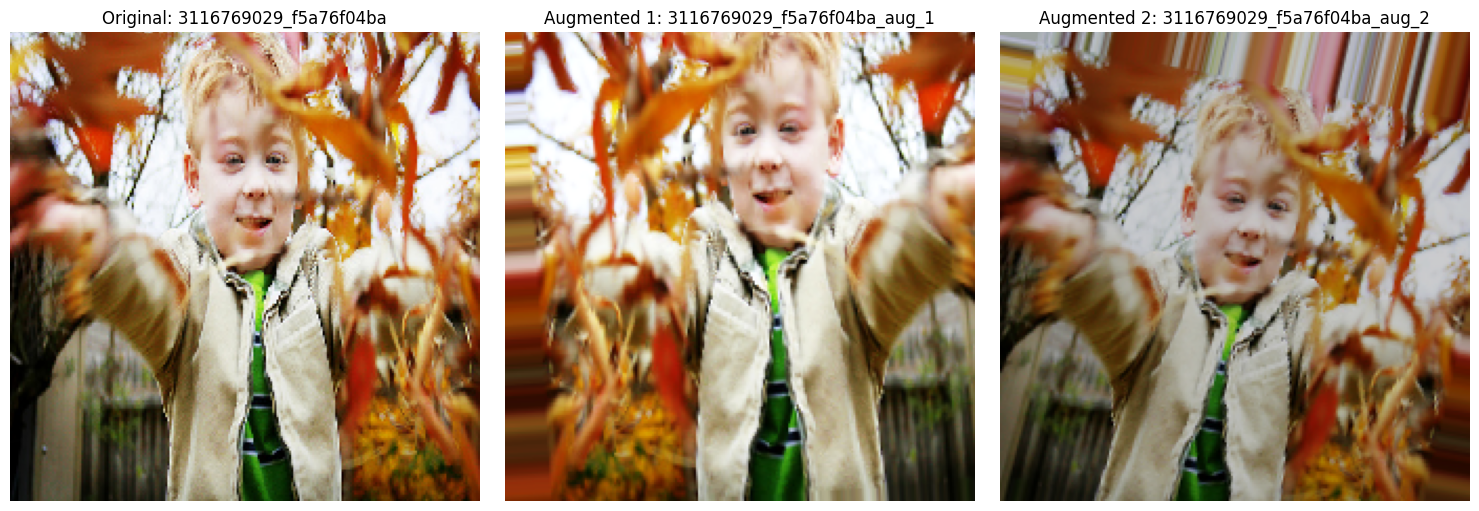

📝 Sample caption: startseq boy in tan coat throws some red leaves at the camera endseq
✅ Augmented images generated using same transformations as training


In [12]:
# Display example: 1 original image and its 2 augmented versions created in cell 16
print("📸 AUGMENTATION EXAMPLE - Images created in previous step:")

if USE_AUGMENTATION and len(final_train_ids) > 0:
    # Find an original image that has augmented versions
    sample_original_id = None
    for img_id in train_image_ids[10:11]:  
        if img_id in final_captions_mapping:
            sample_original_id = img_id
            break
    
    if sample_original_id:
        # Check if augmented versions exist in our dataset
        aug_id_1 = f"{sample_original_id}_aug_1"
        aug_id_2 = f"{sample_original_id}_aug_2"
        
        print(f"🖼️  Original image: {sample_original_id}")
        print(f"🔄 Augmented images: {aug_id_1}, {aug_id_2}")
        
        if aug_id_1 in final_captions_mapping and aug_id_2 in final_captions_mapping:
            print(f"✅ Found original + 2 augmented versions in dataset")
            print(f"   • Original captions: {len(final_captions_mapping[sample_original_id])}")
            print(f"   • Aug_1 captions: {len(final_captions_mapping[aug_id_1])}")  
            print(f"   • Aug_2 captions: {len(final_captions_mapping[aug_id_2])}")
            
            # Generate and show original + augmented images
            try:
                img_path = os.path.join(img_dir, f"{sample_original_id}.jpg")
                if os.path.exists(img_path):
                    # Load original image
                    original_image = load_img(img_path, target_size=(224, 224))
                    original_array = img_to_array(original_image)
                    original_array = np.expand_dims(original_array, axis=0)
                    
                    # Create augmentation generator (same as used in training)
                    datagen = ImageDataGenerator(
                        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
                        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
                        brightness_range=[0.8, 1.2], fill_mode='nearest'
                    )
                    
                    # Generate augmented versions (with seed for reproducibility)
                    aug_iter = datagen.flow(original_array, batch_size=1, seed=42)
                    aug_image_1 = next(aug_iter)[0].astype(np.uint8)  # First augmented version
                    aug_image_2 = next(aug_iter)[0].astype(np.uint8)  # Second augmented version
                    
                    # Display all 3 images
                    plt.figure(figsize=(15, 5))
                    
                    # Original image
                    plt.subplot(1, 3, 1)
                    plt.imshow(original_image)
                    plt.title(f"Original: {sample_original_id}", fontsize=12)
                    plt.axis('off')
                    
                    # First augmented image
                    plt.subplot(1, 3, 2)
                    plt.imshow(aug_image_1)
                    plt.title(f"Augmented 1: {aug_id_1}", fontsize=12)
                    plt.axis('off')
                    
                    # Second augmented image
                    plt.subplot(1, 3, 3)
                    plt.imshow(aug_image_2)
                    plt.title(f"Augmented 2: {aug_id_2}", fontsize=12)
                    plt.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"📝 Sample caption: {final_captions_mapping[sample_original_id][0]}")
                    print(f"✅ Augmented images generated using same transformations as training")
                    
            except Exception as e:
                print(f"❌ Error loading image: {str(e)}")
        else:
            print(f"⚠️  Augmented versions not found in final dataset")
    else:
        print(f"⚠️  No suitable original image found for demonstration")
        
else:
    print("⚠️  Augmentation not enabled or no training images available")

In [13]:
# 🔍 KIỂM TRA TÍNH NHẤT QUÁN CỦA PREPROCESSING
print("🔍 CHECKING PREPROCESSING CONSISTENCY...")

# Kiểm tra shape và preprocessing của một vài ảnh mẫu
def check_preprocessing_consistency(sample_ids, img_dir, max_check=3):
    """Kiểm tra tính nhất quán của preprocessing ảnh"""
    
    print(f"📋 Checking {min(len(sample_ids), max_check)} sample images...")
    
    for i, img_id in enumerate(sample_ids[:max_check]):
        try:
            img_path = os.path.join(img_dir, f"{img_id}.jpg")
            if not os.path.exists(img_path):
                print(f"   ❌ {img_id}: File not found")
                continue
            
            # Method 1: Load như trong augmentation (cell 16)
            image1 = load_img(img_path, target_size=(224, 224))
            array1 = img_to_array(image1)
            print(f"   📸 {img_id}:")
            print(f"      • load_img + img_to_array: {array1.shape} {array1.dtype}")
            print(f"      • Value range: [{array1.min():.1f}, {array1.max():.1f}]")
            
            # Method 2: Preprocess như trong feature extraction (cell 20)  
            array1_expanded = np.expand_dims(array1, axis=0)
            processed = preprocess_input(array1_expanded.copy())  # copy để tránh modify
            print(f"      • After preprocess_input: {processed.shape} {processed.dtype}")
            print(f"      • Value range: [{processed.min():.1f}, {processed.max():.1f}]")
            
            # Kiểm tra feature extraction shape
            if 'feature_extractor' in globals():
                try:
                    features = feature_extractor.predict(processed, verbose=0)
                    print(f"      • VGG16 features: {features.shape} {features.dtype}")
                    print(f"      • Feature range: [{features.min():.3f}, {features.max():.3f}]")
                except Exception as e:
                    print(f"      • Feature extraction error: {e}")
            
            print()
            
        except Exception as e:
            print(f"   ❌ {img_id}: Error - {e}")
    
    return True

# Kiểm tra một số ảnh từ tập training và test
print("\n🔍 CHECKING TRAINING IMAGES:")
check_preprocessing_consistency(final_train_ids, img_dir, max_check=2)

print("\n🔍 CHECKING TEST IMAGES:")  
check_preprocessing_consistency(final_test_ids, img_dir, max_check=2)

print("✅ Preprocessing consistency check completed!")

🔍 CHECKING PREPROCESSING CONSISTENCY...

🔍 CHECKING TRAINING IMAGES:
📋 Checking 2 sample images...
   📸 2874984466_1aafec2c9f:
      • load_img + img_to_array: (224, 224, 3) float32
      • Value range: [0.0, 255.0]
      • After preprocess_input: (1, 224, 224, 3) float32
      • Value range: [-123.7, 151.1]

   📸 519228867_2fd25e38d4:
      • load_img + img_to_array: (224, 224, 3) float32
      • Value range: [0.0, 255.0]
      • After preprocess_input: (1, 224, 224, 3) float32
      • Value range: [-123.7, 151.1]


🔍 CHECKING TEST IMAGES:
📋 Checking 2 sample images...
   📸 3153067758_53f003b1df:
      • load_img + img_to_array: (224, 224, 3) float32
      • Value range: [0.0, 255.0]
      • After preprocess_input: (1, 224, 224, 3) float32
      • Value range: [-123.7, 151.1]

   📸 3449170348_34dac4a380:
      • load_img + img_to_array: (224, 224, 3) float32
      • Value range: [0.0, 255.0]
      • After preprocess_input: (1, 224, 224, 3) float32
      • Value range: [-123.7, 151.1]


# Step 6: Feature Extraction (After Augmentation)

Now we extract VGG16 features for:
- 🔄 Training set: Original + augmented images
- 📷 Test set: Original images only

This ensures clean separation between training and test features.

In [ ]:
# Load VGG16 model for feature extraction
print("🔄 Loading VGG16 model...")
vgg_model = VGG16()
# Remove the last classification layer to get features
feature_extractor = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
print("✅ VGG16 feature extractor ready")
print(f"   Input shape: {feature_extractor.input_shape}")
print(f"   Output shape: {feature_extractor.output_shape}")

def extract_features_for_image_set(image_ids, img_dir, model, desc="Extracting features"):
    """Extract VGG16 features for a set of images"""
    features = {}
    datagen = ImageDataGenerator(
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        brightness_range=[0.8, 1.2], fill_mode='nearest'
    )
    
    for img_id in tqdm(image_ids, desc=desc):
        try:
            if '_aug_' in img_id:
                # For augmented images, we need to generate the augmented version
                original_id = img_id.split('_aug_')[0]
                aug_num = int(img_id.split('_aug_')[1])
                
                img_path = os.path.join(img_dir, f"{original_id}.jpg")
                if not os.path.exists(img_path):
                    continue
                
                # Load and create augmented version
                image = load_img(img_path, target_size=(224, 224))
                image_array = img_to_array(image)
                image_array = np.expand_dims(image_array, axis=0)
                
                # Generate augmented version (with seed for reproducibility)
                aug_iter = datagen.flow(image_array, batch_size=1, seed=42)
                for _ in range(aug_num):  # Generate the specific augmented version
                    aug_image = next(aug_iter)[0]
                
                # Preprocess for VGG16
                processed_image = preprocess_input(np.expand_dims(aug_image, axis=0))
                
            else:
                # For original images
                img_path = os.path.join(img_dir, f"{img_id}.jpg")
                if not os.path.exists(img_path):
                    continue
                
                image = load_img(img_path, target_size=(224, 224))
                image_array = img_to_array(image)
                processed_image = preprocess_input(np.expand_dims(image_array, axis=0))
            
            # Extract features
            feature = model.predict(processed_image, verbose=0)
            features[img_id] = feature
            
        except Exception as e:
            print(f"❌ Error processing {img_id}: {str(e)}")
            continue
    
    return features

print("🔄 Extracting features for all images...")

In [ ]:
# 🔧 SỬA LẠI FEATURE EXTRACTION để đảm bảo shape nhất quán
def extract_features_for_image_set_fixed(image_ids, img_dir, model, desc="Extracting features"):
    """
    Extract VGG16 features với shape nhất quán
    - Output: features[img_id] có shape (4096,) thay vì (1, 4096)
    """
    features = {}
    datagen = ImageDataGenerator(
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        brightness_range=[0.8, 1.2], fill_mode='nearest'
    )
    
    for img_id in tqdm(image_ids, desc=desc):
        try:
            if '_aug_' in img_id:
                # For augmented images, we need to generate the augmented version
                original_id = img_id.split('_aug_')[0]
                aug_num = int(img_id.split('_aug_')[1])
                
                img_path = os.path.join(img_dir, f"{original_id}.jpg")
                if not os.path.exists(img_path):
                    continue
                
                # Load and create augmented version
                image = load_img(img_path, target_size=(224, 224))
                image_array = img_to_array(image)
                image_array = np.expand_dims(image_array, axis=0)
                
                # Generate augmented version (with seed for reproducibility)
                aug_iter = datagen.flow(image_array, batch_size=1, seed=42)
                for _ in range(aug_num):  # Generate the specific augmented version
                    aug_image = next(aug_iter)[0]
                
                # Preprocess for VGG16
                processed_image = preprocess_input(np.expand_dims(aug_image, axis=0))
                
            else:
                # For original images
                img_path = os.path.join(img_dir, f"{img_id}.jpg")
                if not os.path.exists(img_path):
                    continue
                
                image = load_img(img_path, target_size=(224, 224))
                image_array = img_to_array(image)
                processed_image = preprocess_input(np.expand_dims(image_array, axis=0))
            
            # Extract features và flatten về (4096,)
            feature = model.predict(processed_image, verbose=0)
            
            # 🔧 CRITICAL FIX: Đảm bảo shape (4096,) thay vì (1, 4096)
            if feature.ndim == 2 and feature.shape[0] == 1:
                feature = feature.squeeze(axis=0)  # (1, 4096) -> (4096,)
            elif feature.ndim == 2:
                feature = feature[0]  # Lấy sample đầu tiên nếu batch > 1
                
            # Đảm bảo dtype float32 cho compatibility
            feature = feature.astype(np.float32)
            
            features[img_id] = feature
            
        except Exception as e:
            print(f"❌ Error processing {img_id}: {str(e)}")
            continue
    
    return features

# Test function mới với mẫu nhỏ
print("\n🔧 Testing FIXED feature extraction...")
test_fixed_features = extract_features_for_image_set_fixed(
    final_train_ids[:2], img_dir, feature_extractor, 
    "Testing fixed extraction"
)

print(f"\n📊 FIXED EXTRACTION RESULTS:")
for img_id, feature in test_fixed_features.items():
    print(f"   • {img_id}: shape={feature.shape}, dtype={feature.dtype}")
    print(f"     Range: [{feature.min():.3f}, {feature.max():.3f}]")

# Verify với data generator format
if len(test_fixed_features) > 0:
    sample_feature = next(iter(test_fixed_features.values()))
    if sample_feature.shape == (4096,) and sample_feature.dtype == np.float32:
        print("✅ Fixed extraction produces correct format for data generator!")
    else:
        print(f"⚠️ Still has issues: shape={sample_feature.shape}, dtype={sample_feature.dtype}")

print("\n🎯 Use 'extract_features_for_image_set_fixed' for final extraction")

In [ ]:
# Extract features for training set (original + augmented) - FIXED VERSION
train_features = extract_features_for_image_set_fixed(
    final_train_ids, img_dir, feature_extractor, 
    "Extracting training features (original + augmented)"
)

# Extract features for test set (original only) - FIXED VERSION
test_features = extract_features_for_image_set_fixed(
    final_test_ids, img_dir, feature_extractor,
    "Extracting test features (original only)"
)

# Combine all features
all_features = {**train_features, **test_features}

print(f"\n📊 FEATURE EXTRACTION COMPLETED:")
print(f"   Training features: {len(train_features):,}")
print(f"   Test features: {len(test_features):,}")
print(f"   Total features: {len(all_features):,}")

# Verify feature shapes
sample_feature = next(iter(all_features.values()))
print(f"   Feature shape: {sample_feature.shape}")

# Save features
train_features_path = os.path.join(OUTPUT_DIR, 'train_features.pkl')
test_features_path = os.path.join(OUTPUT_DIR, 'test_features.pkl')
all_features_path = os.path.join(OUTPUT_DIR, 'all_features.pkl')

pickle.dump(train_features, open(train_features_path, 'wb'))
pickle.dump(test_features, open(test_features_path, 'wb'))
pickle.dump(all_features, open(all_features_path, 'wb'))

print(f"\n💾 Features saved:")
print(f"   Training features: {train_features_path}")
print(f"   Test features: {test_features_path}")
print(f"   All features: {all_features_path}")

print(f"\n🎯 PHASE 1 COMPLETED - Data leakage prevention implemented!")
print(f"✅ Train/test split done BEFORE augmentation and tokenization")
print(f"✅ Tokenizer fitted on training data only") 
print(f"✅ Augmentation applied to training set only")
print(f"✅ Features extracted with proper separation")

# Phase 2: Model Training Pipeline

Now we implement the model training components using our clean, leakage-free data.

# Step 7: Data Generator

Create a data generator that works with our clean train/test split and uses only training data vocabulary.

In [17]:
def data_generator(image_ids, captions_map, features, tokenizer,
                   max_len, vocab_size, batch_size):
    X1b, X2b, Yb = [], [], []
    while True:
        for img_id in image_ids:
            # feature: (4096,) float32
            feat = features.get(img_id, None)
            if feat is None:
                continue
            feat = np.asarray(feat)
            if feat.ndim == 2:
                feat = feat.squeeze()
            if feat.shape != (4096,):
                continue
            feat = feat.astype(np.float32, copy=False)

            # captions for this image
            for cap in captions_map.get(img_id, []):
                seq = tokenizer.texts_to_sequences([cap])[0]
                if len(seq) < 2:
                    continue

                # teacher forcing pairs
                for i in range(1, len(seq)):
                    in_seq_raw = seq[:i]
                    in_seq = pad_sequences(
                        [in_seq_raw],
                        maxlen=max_len,
                        padding="pre",     # ✅ left-padding (default behavior)
                        truncating="pre"
                    )[0].astype(np.int32)

                    out_tok = to_categorical(
                        [seq[i]], num_classes=vocab_size
                    )[0].astype(np.float32)

                    X1b.append(feat)      # (4096,)
                    X2b.append(in_seq)    # (max_len,)
                    Yb.append(out_tok)    # (vocab_size,)

                    if len(X1b) == batch_size:
                        X1 = np.stack(X1b, 0).astype(np.float32)  # (B,4096)
                        X2 = np.stack(X2b, 0).astype(np.int32)    # (B,max_len)
                        Y  = np.stack(Yb,  0).astype(np.float32)  # (B,vocab)
                        yield (X1, X2), Y                          # ✅ tuple, not list
                        X1b.clear(); X2b.clear(); Yb.clear()

        # flush remainder (optional but useful)
        if X1b:
            X1 = np.stack(X1b, 0).astype(np.float32)
            X2 = np.stack(X2b, 0).astype(np.int32)
            Y  = np.stack(Yb,  0).astype(np.float32)
            yield (X1, X2), Y
            X1b.clear(); X2b.clear(); Yb.clear()

# Step 8: LSTM Model Architecture with Attention

Build the encoder-decoder model with attention mechanism for image captioning.

In [20]:
# Load all necessary pre-trained components
all_features_path = os.path.join(OUTPUT_DIR, 'all_features.pkl')
tokenizer_path = os.path.join(OUTPUT_DIR, 'tokenizer_train_only.pkl')

print("📥 Loading pre-trained components...")

# Load features
if os.path.exists(all_features_path):
    print("   Loading features...")
    with open(all_features_path, 'rb') as f:
        all_features = pickle.load(f)
    print(f"   ✅ Features loaded: {len(all_features):,} images")
    
    # Verify feature shapes
    sample_feature = next(iter(all_features.values()))
    print(f"   Feature shape: {sample_feature.shape}")
else:
    print("   ⚠️  all_features.pkl not found. Need to run feature extraction...")

# Load tokenizer
if os.path.exists(tokenizer_path):
    print("   Loading tokenizer...")
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    # Recalculate vocabulary parameters
    vocab_size = len(tokenizer.word_index) + 1
    
    # Calculate max_caption_length if not already defined
    if 'max_caption_length' not in locals():
        # Use a reasonable default or calculate from training data
        max_caption_length = 20  # Default value
    
    print(f"   ✅ Tokenizer loaded: vocab_size={vocab_size:,}")
    print(f"   Max caption length: {max_caption_length}")
else:
    print("   ⚠️  tokenizer_train_only.pkl not found. Need to run tokenization...")

print(f"\n🎯 COMPONENT LOADING COMPLETED!")
print("✅ Ready for model building and training")

📥 Loading pre-trained components...
   Loading features...
   ✅ Features loaded: 22,653 images
   Feature shape: (4096,)
   Loading tokenizer...
   ✅ Tokenizer loaded: vocab_size=8,354
   Max caption length: 34

🎯 COMPONENT LOADING COMPLETED!
✅ Ready for model building and training


In [19]:
print("🔧 Building GRU model with simple dot-attention...")

from keras import Model, Input
from keras.layers import Dense, Dropout, Embedding, GRU, RepeatVector, Concatenate, Activation, Lambda, Dot
from keras import ops  # Keras 3
import tensorflow as tf

# ----- Inputs -----
inputs1 = Input(shape=(4096,), dtype='float32', name='img_feat')
inputs2 = Input(shape=(max_caption_length,), dtype='int32', name='token_ids')

# ----- Image encoder (vector -> time-aligned) -----
x_img = Dropout(0.5)(inputs1)
img_vec = Dense(256, activation='relu')(x_img)                 # (B, 256)
img_seq = RepeatVector(max_caption_length)(img_vec)            # (B, T, 256)
img_seq = GRU(
    256,
    return_sequences=True,
    recurrent_dropout=0.1,   # ép non-cuDNN
    reset_after=False,       # ép non-cuDNN
    unroll=True              # optional: càng chắc chắn non-cuDNN
)(img_seq)

# ----- Text encoder (seq -> features over time) -----
emb = Embedding(vocab_size, 256, mask_zero=True, input_length=max_caption_length)(inputs2)  # (B, T, 256)
emb = Dropout(0.5)(emb)
txt_seq = GRU(
    256,
    return_sequences=True,
    recurrent_dropout=0.1,   # ép non-cuDNN
    reset_after=False,       # ép non-cuDNN
    unroll=True              # optional
)(emb)

# ----- Dot-attention -----
# scores[b, i, j] = <img_seq[b,i,:], txt_seq[b,j,:]>
scores = Dot(axes=[2, 2])([img_seq, txt_seq])                  # (B, T, T)
attn = Activation('softmax')(scores)                           # softmax over j (last axis)

# context[b, i, f] = sum_j attn[b,i,j] * txt_seq[b,j,f]
context = Lambda(
    lambda x: tf.einsum('bij,bjf->bif', x[0], x[1]),
    output_shape=lambda shapes: (shapes[0][0], shapes[0][1], shapes[1][2]),  # (B, T, F)
    name="dot_attention_context"
)([attn, txt_seq])

# Tổng hợp theo thời gian i
context_vec = ops.sum(context, axis=1)                         # (B, 256)

# ----- Decoder (1 step) -----
dec_in = Concatenate()([context_vec, img_vec])                 # (B, 512)
h = Dense(256, activation='relu')(dec_in)
outputs = Dense(vocab_size, activation='softmax')(h)

model = Model([inputs1, inputs2], outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())
print("✅ GRU + dot-attention model created.")


🔧 Building GRU model with simple dot-attention...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_feat            │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ img_feat[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,138,624 │ token_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 34, 256)   │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ token_ids[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 34, 256)   │    393,984 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 34, 256)   │    393,984 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 34, 34)    │          0 │ gru[0][0],        │
│                     │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 34, 34)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_attention_cont… │ (None, 34, 256)   │          0 │ activation[0][0], │
│ (Lambda)            │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum (Sum)           │ (None, 256)       │          0 │ dot_attention_co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ sum[0][0],        │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8354)      │  2,146,978 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,253,730 (23.86 MB)

 Trainable params: 6,253,730 (23.86 MB)

 Non-trainable params: 0 (0.00 B)

None
✅ GRU + dot-attention model created.


# Step 9: Training Configuration

Calculate training parameters based on our augmented dataset with proper data separation.

In [20]:
# Training configuration
epochs = 50
batch_size = 32

print(f"🚀 TRAINING CONFIGURATION:")
print(f"   Epochs: {epochs}")
print(f"   Batch Size: {batch_size}")
print(f"   Vocabulary Size: {vocab_size:,}")
print(f"   Max Caption Length: {max_caption_length}")

# Calculate training samples and steps
def calculate_training_samples(image_ids, captions_mapping, max_caption_length):
    """Calculate total training samples (sequences) for step calculation"""
    total_samples = 0
    for img_id in image_ids:
        if img_id in captions_mapping:
            for caption in captions_mapping[img_id]:
                # Each caption generates (caption_length - 1) training samples
                caption_length = len(caption.split())
                # Limit to max_caption_length for consistency
                effective_length = min(caption_length, max_caption_length)
                total_samples += max(1, effective_length - 1)  # At least 1 sample per caption
    return total_samples

# Calculate samples for training and validation
train_samples = calculate_training_samples(final_train_ids, final_captions_mapping, max_caption_length)
test_samples = calculate_training_samples(final_test_ids, final_captions_mapping, max_caption_length)

# Calculate steps per epoch
steps_per_epoch = max(1, ceil(train_samples / batch_size))
validation_steps = max(1, ceil(test_samples / batch_size))

print(f"\n📊 DATASET STATISTICS:")
print(f"   Training images: {len(final_train_ids):,}")
print(f"   Test images: {len(final_test_ids):,}")
print(f"   Training samples (sequences): {train_samples:,}")
print(f"   Test samples (sequences): {test_samples:,}")

print(f"\n🎯 TRAINING STEPS:")
print(f"   Steps per epoch: {steps_per_epoch:,}")
print(f"   Validation steps: {validation_steps:,}")
print(f"   Total training steps: {steps_per_epoch * epochs:,}")

# Verify data availability
missing_train_features = [img_id for img_id in final_train_ids if img_id not in all_features]
missing_test_features = [img_id for img_id in final_test_ids if img_id not in all_features]

if missing_train_features:
    print(f"⚠️  Missing training features: {len(missing_train_features)} images")
if missing_test_features:
    print(f"⚠️  Missing test features: {len(missing_test_features)} images")

print(f"\n✅ Training configuration completed!")
print(f"🎯 Ready to train model with {train_samples:,} training samples over {epochs} epochs")

🚀 TRAINING CONFIGURATION:
   Epochs: 50
   Batch Size: 32
   Vocabulary Size: 8,354
   Max Caption Length: 34

📊 DATASET STATISTICS:
   Training images: 21,843
   Test images: 810
   Training samples (sequences): 1,115,421
   Test samples (sequences): 41,558

🎯 TRAINING STEPS:
   Steps per epoch: 34,857
   Validation steps: 1,299
   Total training steps: 1,742,850

✅ Training configuration completed!
🎯 Ready to train model with 1,115,421 training samples over 50 epochs


# Step 10: Model Training

Train the LSTM model using our clean, leakage-free pipeline with proper train/validation split.

In [ ]:
print("🚀 Starting model training with leakage-free pipeline...")
print(f"📊 Training: {len(final_train_ids)} images → {train_samples:,} samples")
print(f"📊 Validation: {len(final_test_ids)} images → {test_samples:,} samples")

# Import callbacks for early stopping and model checkpointing
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

best_model_path = os.path.join(OUTPUT_DIR, 'best_model.keras')  

# Early stopping - stop if val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint - save best model based on validation loss
model_checkpoint = ModelCheckpoint(
    best_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


callbacks = [early_stopping, model_checkpoint, reduce_lr]

print(f"� Training callbacks configured:")
print(f"   • Early stopping: patience=3 epochs")
print(f"   • Model checkpoint: saving best model to {best_model_path}")
print(f"   • Learning rate reduction: factor=0.5, patience=2")

# Training with clean data generators and callbacks
try:
    # Create data generators
    train_generator = data_generator(
        final_train_ids, final_captions_mapping, all_features, 
        tokenizer, max_caption_length, vocab_size, batch_size
    )
    
    validation_generator = data_generator(
        final_test_ids, final_captions_mapping, all_features, 
        tokenizer, max_caption_length, vocab_size, batch_size
    )
    
    # Train the model with callbacks
    print(f"\n🚀 Starting training for {epochs} epochs with early stopping...")
    print(f"📊 Training setup:")
    print(f"   • Steps per epoch: {steps_per_epoch}")
    print(f"   • Validation steps: {validation_steps}")
    print(f"   • Batch size: {batch_size}")
    print(f"   • Expected format: Epoch X/{epochs}")
    print(f"   • Progress: [==============================] - time - loss: X.XXXX - accuracy: X.XXXX - val_loss: X.XXXX - val_accuracy: X.XXXX")
    print(f"\n" + "="*80)
    print("📈 TRAINING PROGRESS:")
    print("="*80)

    ###
    x, y = next(train_generator)

    # x phải là tuple, không phải list:
    if isinstance(x, list):
        x = tuple(x)

    X1, X2 = x

    # ép dtype/shape đúng chuẩn
    X1 = np.asarray(X1, dtype=np.float32)                 # (B, 4096)
    if X1.ndim == 1: X1 = X1[None, :]                     # edge case (4096,) -> (1,4096)

    X2 = np.asarray(X2, dtype=np.int32)                   # (B, max_caption_length)
    if X2.ndim == 1: X2 = X2[None, :]                     # edge case

    Y  = np.asarray(y,  dtype=np.float32)                 # (B, vocab_size)

    # kiểm tra kỹ
    assert X1.ndim == 2 and X1.shape[1] == 4096,          f"X1 bad shape {X1.shape}"
    assert X2.ndim == 2 and X2.shape[1] == max_caption_length, f"X2 bad shape {X2.shape}"
    assert Y.ndim  == 2 and Y.shape[1]  == vocab_size,    f"Y bad shape {Y.shape}"

    assert X2.dtype == np.int32,  f"X2 dtype {X2.dtype} should be int32"
    assert X1.dtype == np.float32 and Y.dtype == np.float32

    # kiểm tra NaN/Inf
    for name, arr in [("X1", X1), ("X2", X2), ("Y", Y)]:
        assert np.isfinite(arr).all(), f"{name} contains NaN/Inf"

    print("✅ one batch OK:", X1.shape, X2.shape, Y.shape)


    ###
    
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1    )
    
    print("\n🎉 Training completed successfully!")
    
    # Print training summary
    final_epoch = len(history.history['loss'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    print(f"\n📊 TRAINING SUMMARY:")
    print(f"   • Total epochs trained: {final_epoch}")
    print(f"   • Final train loss: {final_train_loss:.4f}")
    print(f"   • Final validation loss: {final_val_loss:.4f}")
    print(f"   • Final train accuracy: {final_train_acc:.4f}")
    print(f"   • Final validation accuracy: {final_val_acc:.4f}")
    
    # Load best model for evaluation
    if os.path.exists(best_model_path):
        print(f"\n📥 Loading best model from: {best_model_path}")
        model = keras.saving.load_model(best_model_path)  # dùng keras.saving
        print("✅ Best model loaded successfully!")
    
except KeyboardInterrupt:
    print("\n⏹️  Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training error: {str(e)}")
    print("   Continuing with evaluation on current model state...")

# Save final model (backup)
final_model_path = os.path.join(OUTPUT_DIR, 'final_model.keras')
model.save(final_model_path)
print(f"\n💾 Final model saved: {final_model_path}")

print(f"\n🏁 TRAINING PHASE COMPLETED!")
print(f"✅ Model trained on {len(final_train_ids):,} training images")
print(f"✅ Validated on {len(final_test_ids):,} test images")
print(f"✅ Best model saved with early stopping")
print(f"✅ No data leakage - clean train/test separation maintained")

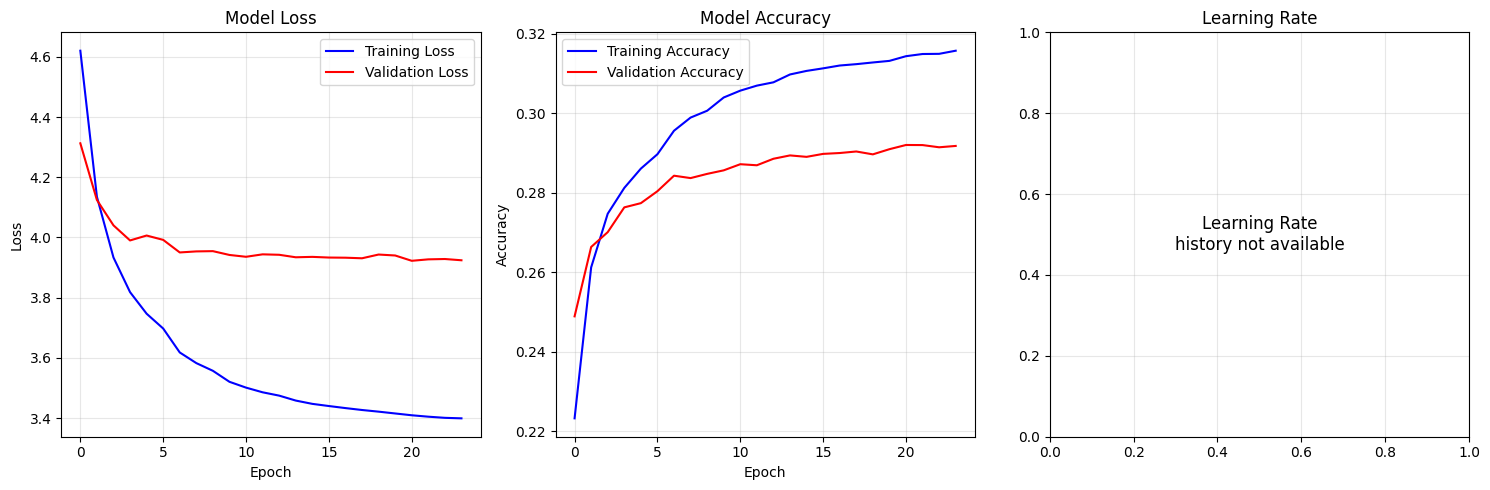

📊 Training history plot saved: /home/viethung/anhthu/ICG/output/training_history.png

🏆 BEST PERFORMANCE:
   • Best validation loss: 3.9226 (epoch 21)
   • Best validation accuracy: 0.2921 (epoch 21)


In [22]:
# Plot training history
if 'history' in locals() and history is not None:
    plt.figure(figsize=(15, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training & validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    plt.subplot(1, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', color='green')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nhistory not available', 
                ha='center', va='center', fontsize=12)
        plt.title('Learning Rate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Training history plot saved: {plot_path}")
    
    # Print best epoch information
    best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = min(history.history['val_loss'])
    best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    
    print(f"\n🏆 BEST PERFORMANCE:")
    print(f"   • Best validation loss: {best_val_loss:.4f} (epoch {best_val_loss_epoch})")
    print(f"   • Best validation accuracy: {best_val_acc:.4f} (epoch {best_val_acc_epoch})")
    
else:
    print("⚠️  Training history not available for plotting")

# Step 11: Model Evaluation with BLEU Score

Evaluate the trained model on the clean test set using BLEU metrics.

In [23]:
# 1) Hard reset graph + ép float32 toàn cục TRƯỚC khi load model
import os, builtins
import tensorflow as tf
from tensorflow.keras import mixed_precision
import keras

tf.keras.backend.clear_session()
mixed_precision.set_global_policy('float32')   # tắt mixed-precision -> mọi tensor float32
builtins.tf = tf                                # hack an toàn: đảm bảo tên 'tf' luôn tồn tại trong global/builtins

# 2) Load model: cấp 'tf' vào custom_objects để Lambda(tf.einsum, ...) tìm thấy
best_model_path = "/home/viethung/anhthu/ICG/output/best_model.keras"
model = keras.saving.load_model(
    best_model_path,
    safe_mode=False,
    compile=True,
    custom_objects={'tf': tf}   # rất quan trọng
)

# 3) Kiểm thử nhanh: chạy 1 predict giả để validate Lambda
import numpy as np
T = 34   # đúng = max_caption_length của bạn
vocab = model.outputs[0].shape[-1] if hasattr(model.outputs[0].shape[-1], '__int__') else None

# giả lập 1 batch hợp lệ: ảnh (1,4096) float32; seq (1,T) int32
dummy_img = np.zeros((1, 4096), dtype=np.float32)
dummy_seq = np.zeros((1, T), dtype=np.int32)
_ = model.predict([dummy_img, dummy_seq], verbose=0)  # nếu qua được là OK
print("✅ Sanity check passed.")


✅ Sanity check passed.


In [35]:
# ===== Imports cần thiết =====
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

# ===== Helpers =====
def build_index2word(tokenizer):
    """Build once: map chỉ số -> từ (O(1) lookup)."""
    return {idx: w for w, idx in tokenizer.word_index.items()}

def clean_caption_tokens(tokens):
    """Bỏ startseq/endseq nếu có."""
    if tokens and tokens[0] == 'startseq':
        tokens = tokens[1:]
    if tokens and tokens[-1] == 'endseq':
        tokens = tokens[:-1]
    return tokens



In [36]:
def predict_caption(model, image_features, tokenizer, max_caption_length, index2word=None):
    """
    Sinh caption từng từ (greedy).
    - image_features: (4096,) hoặc (1,4096) -> sẽ reshape về (1,4096) float32.
    - Left-pad: padding='pre', truncating='pre'.
    """
    if index2word is None:
        index2word = build_index2word(tokenizer)

    caption = ['startseq']  # dùng list để nối nhanh, cuối cùng join
    img = np.asarray(image_features, dtype=np.float32).reshape(1, -1)  # (1,4096)

    for _ in range(max_caption_length):
        seq = tokenizer.texts_to_sequences([' '.join(caption)])[0]
        seq = pad_sequences([seq], maxlen=max_caption_length,
                            padding='pre', truncating='pre')  # (1,T), int32

        yhat = model.predict([img, seq], verbose=0)   # (1, vocab)
        # Lấy argmax logits trên chiều vocab
        idx = int(np.argmax(yhat[0], axis=-1))

        # 0 thường là PAD -> nếu model ra 0 thì dừng để tránh vòng lặp vô hạn
        if idx == 0:
            break

        word = index2word.get(idx, None)
        if word is None:
            break

        caption.append(word)
        if word == 'endseq':
            break

    # Làm sạch
    tokens = clean_caption_tokens(caption)
    return ' '.join(tokens)



In [26]:
# ===== Evaluation (Simplified) =====
from nltk.translate.bleu_score import corpus_bleu

index2word = build_index2word(tokenizer)

actual_captions_list = []     # list of list-of-token-lists (references)
predicted_captions_list = []  # list of token-lists (hypotheses)

for img_id in final_test_ids:
    try:
        if img_id not in all_features:
            continue

        actual_captions = final_captions_mapping[img_id]
        refs = [clean_caption_tokens(c.strip().split()) for c in actual_captions]
        refs = [r for r in refs if len(r) > 0]
        if not refs:
            continue

        pred = predict_caption(model, all_features[img_id], tokenizer, max_caption_length, index2word=index2word)
        hyp = pred.strip().split()

        actual_captions_list.append(refs)
        predicted_captions_list.append(hyp)

    except Exception:
        continue

# ===== BLEU =====
if actual_captions_list and predicted_captions_list:
    bleu1 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0))
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
else:
    print("❌ No valid predictions to calculate BLEU scores")


BLEU-1: 0.4177
BLEU-2: 0.1843
